In [602]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import pickle

In [603]:
df1 = pd.read_csv("data/go_emotion_1.csv")
df2 = pd.read_csv("data/go_emotion_2.csv")

emotions = pd.read_csv("data/emotion_mappings.csv")

df = pd.concat([df1, df2], axis=0, ignore_index=True)

df = df[df['emotion_id'].str.contains(",") != True][["text", "emotion_id"]]
df["emotion_id"] =  df['emotion_id'].astype("int")


In [604]:
# Mapping the emotions to their ids

df = pd.merge(df, emotions, how="left", left_on="emotion_id", right_on="id").drop(["emotion_id", "id"], axis=1)

extra_data = pd.read_csv("data/extra_data.csv").rename(columns={"Text":"text", "Emotion": "emotions"})
df = pd.concat([df, extra_data], axis=0, ignore_index=True)

df

,text,emotions
0,My favourite food is anything I didn't have to...,neutral
1,"Now if he does off himself, everyone will thin...",neutral
2,WHY THE FUCK IS BAYLESS ISOING,anger
3,To make her feel threatened,fear
4,Dirty Southern Wankers,annoyance
...,...,...
68289,i begun to feel distressed for you,fear
68290,i left feeling annoyed and angry thinking that...,anger
68291,i were to ever get married i d have everything...,joy
68292,i feel reluctant in applying there because i w...,fear


Min:  1
Average:  15.223
Max:  66


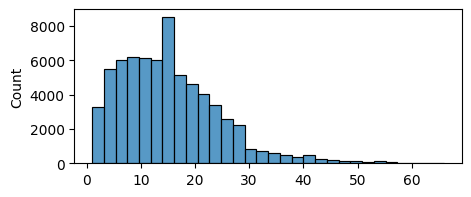

In [605]:
def text_length_distribution(df):
    sentence_length = []

    for text in df[df.columns[0]]:
        sentence_length.append(len(text.split()))
    
    print("Min: ", min(sentence_length))
    print("Average: ", round(sum(sentence_length) / len(sentence_length), 3))
    print("Max: ", max(sentence_length))
    
    plt.figure(figsize=(5, 2))
    sns.histplot(sentence_length, bins=30)

text_length_distribution(df)

In [606]:
df["emotions"].value_counts()

emotions
neutral           14429
sadness            7184
happy              7029
anger              6149
fear               5084
love               3228
admiration         3058
joy                2946
gratitude          2117
approval           2109
amusement          1838
surprise           1686
annoyance          1645
disapproval        1597
curiosity          1565
optimism            968
confusion           955
disappointment      797
caring              735
realization         675
disgust             574
excitement          567
desire              445
remorse             397
embarrassment       226
nervousness          97
relief               95
pride                58
grief                41
Name: count, dtype: int64

In [607]:
# Filtering the data which will not be usefull in the production scenario.


df["outlier"] = df["text"].apply(lambda x: False if len(x.split()) > 10 else True)
df = df[df["outlier"] == False].drop("outlier", axis=1)

required_data = ['anger','fear','sadness','happy', "annoyance"]
no_usecase_emotions = list(set(df["emotions"].unique()).difference(required_data))

for emotion in no_usecase_emotions:
    df = df[df["emotions"] != emotion]


df["emotions"].unique()

array(['annoyance', 'anger', 'sadness', 'fear', 'happy'], dtype=object)

In [608]:
# anger = df[df["emotions"] == "anger"].sample(5000, replace=True)
# fear = df[df["emotions"] == "fear"].sample(5000, replace=True)
# sadness = df[df["emotions"] == "sadness"].sample(955, replace=True)
# happy = df[df["emotions"] == "happy"].sample(955, replace=True)
# annoyance = df[df["emotions"] == "annoyance"].sample(955, replace=True)


# df = pd.concat([anger, fear, sadness, happy], axis=0, ignore_index=True)



# df = df[df["emotions"] != "anger"]
# df = pd.concat([df, anger], axis=0, ignore_index=True)

In [609]:
stopWords = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def nlpTextProcessor(sentence):
    tokenizedSent = word_tokenize(sentence)
    removedStopwords = [word for word in tokenizedSent if word not in stopWords]
    finalOutput = []
    tempOutput = []
    for word in removedStopwords:
        if word not in set("``{['?/]}().,:-@") and word not in ["''"]:
            tempOutput.append(lemmatizer.lemmatize(word))
    finalOutput = " ".join(tempOutput)
    return finalOutput.lower()


df["text"] = df["text"].apply(nlpTextProcessor)

In [610]:
X = df["text"]
y = df["emotions"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)
count_vector = CountVectorizer(ngram_range=(1, 4))

X_train = count_vector.fit_transform(X_train)
X_test = count_vector.transform(X_test)

In [611]:
len(df)

19597

In [612]:
model = MultinomialNB(alpha=1, fit_prior=False)
model.fit(X_train, y_train)

nb_predictions = model.predict(X_test)
print(classification_report(y_test, nb_predictions, zero_division=False))

              precision    recall  f1-score   support

       anger       0.81      0.86      0.83      1065
   annoyance       0.47      0.06      0.10       266
        fear       0.96      0.84      0.90       928
       happy       0.86      0.95      0.90      1367
     sadness       0.79      0.87      0.83      1274

    accuracy                           0.84      4900
   macro avg       0.78      0.71      0.71      4900
weighted avg       0.83      0.84      0.82      4900



In [613]:
def real_world_testing(texts):
    vectorized_texts = count_vector.transform(texts[1:])
    correct_predications = 0
    print("\n\n")
    for i, text in enumerate(vectorized_texts):
        print(str(i+1)+". ",texts[i+1])
        predictions = model.predict(text)
        print("----> Prediction: ", predictions[0], "\n")
        
        if str(predictions[0]) == texts[0]:
            correct_predications += 1

    print("Accuracy: ", round((correct_predications/(len(texts)-1)) * 100,0), "%")

In [617]:
data = [
    "fear",
    "At times, I'm overwhelmed by an intense fear that grips me, rendering me frozen and unable to confront situations that seem even remotely threatening.",
    "This fear feels like an invisible barrier, constantly looming and preventing me from embracing experiences that others might find simple or mundane.",
    "It's as if I'm navigating through a labyrinth of fears, each turn presenting a new set of anxieties that paralyze any attempt to move forward.",
    "This sense of fearfulness seems to echo within, manifesting in a knot of tension that tightens with each perceived threat or worrisome thought.",
    "My fears tend to magnify, transforming ordinary situations into looming catastrophes, making it challenging to see beyond the immediate distress.",
    "There's a constant feeling of vulnerability, like standing on a precipice, expecting the ground to crumble beneath my feet at any given moment.",
    "It's a struggle to rationalize these fears; they often seem illogical, yet their hold over my mind and body feels relentless and all-encompassing.",
    "I wish I could break free from this cycle of fear, to face challenges without this overwhelming sense of dread that shadows every step I take.",
    "Finding the courage to confront these fears feels like an uphill battle, each attempt met with an avalanche of apprehension and uncertainty.",
    "These fears make it hard to embrace life fully, leaving me feeling stifled and held back by an invisible force that refuses to loosen its grip."
]





real_world_testing(data)




1.  At times, I'm overwhelmed by an intense fear that grips me, rendering me frozen and unable to confront situations that seem even remotely threatening.
----> Prediction:  anger 

2.  This fear feels like an invisible barrier, constantly looming and preventing me from embracing experiences that others might find simple or mundane.
----> Prediction:  sadness 

3.  It's as if I'm navigating through a labyrinth of fears, each turn presenting a new set of anxieties that paralyze any attempt to move forward.
----> Prediction:  sadness 

4.  This sense of fearfulness seems to echo within, manifesting in a knot of tension that tightens with each perceived threat or worrisome thought.
----> Prediction:  anger 

5.  My fears tend to magnify, transforming ordinary situations into looming catastrophes, making it challenging to see beyond the immediate distress.
----> Prediction:  anger 

6.  There's a constant feeling of vulnerability, like standing on a precipice, expecting the ground to cr

In [615]:
# Saving the model.
# pickle.dump(model , open('emotion_detection-model.pk1' , 'wb'))